In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms

from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

from tqdm import tqdm

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Теперь попробуем взять новый датасет и самостоятельно написать код подготовки данных, создание сверточной нейросети, её тренировки и валидации

### Задача 1

Напишите сверточную нейросеть для датасета CIFAR10

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:36<00:00, 4715337.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


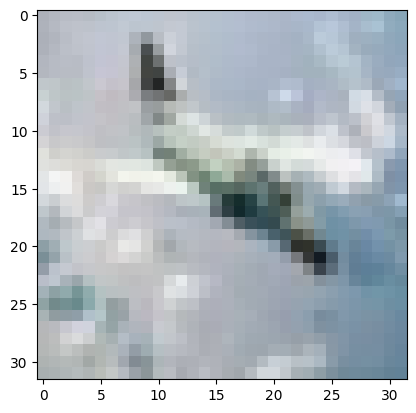

In [3]:
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray');

### Задача 2

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [4]:
next(iter(trainloader))[0].shape

torch.Size([128, 3, 32, 32])

In [5]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.fc1 = nn.Linear(6 * 6 * 128, 128)  # !!!
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        #(32,32)
        x = self.pool(F.relu(self.conv1(x)))
        #(14,14)
        x = self.pool(F.relu(self.conv2(x)))
        #(6,6)
        #print(x.shape)
        x = x.view(-1, 6 * 6 * 128)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [6]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch

        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

100%|██████████| 10/10 [00:40<00:00,  4.09s/it]

Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images.to(device))#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted.cpu().detach() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

acc = [0] * 10
for i in range(10):
    acc[i] = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of {classes[i]}: {round(acc[i], 3)} %')
print(f'Avg acccuracy : {round(np.mean(acc), 3)} %')

Accuracy of plane: 55.172 %
Accuracy of car: 60.714 %
Accuracy of bird: 45.455 %
Accuracy of cat: 41.176 %
Accuracy of deer: 44.444 %
Accuracy of dog: 24.242 %
Accuracy of frog: 61.111 %
Accuracy of horse: 76.0 %
Accuracy of ship: 84.375 %
Accuracy of truck: 64.103 %
Avg acccuracy : 55.679 %
